Support vector machines (SVM) are used in regression and classification probems. Furthermore, they can handle complex, nonlinear data. However, they perform best on small to medium sized data sets.

Basic idea is to fit a maximally sized margin between instances it is separating. The instances are *support vectors*. Soft margin classification is preferred since hard margins:
1. require data that is linearly separable
2. are sensitive to outliers.

Linear SVM computes the weights, $w$, of a decision function: $h(x) = w^T\cdot x + b$. In the binary classification case, the decision is made using:

$$
    y = 0 \textrm{ if } h(x) < 0
$$
$$
    y = 1 \textrm{ if } h(x) \geq 0
$$



In [112]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

iris = datasets.load_iris()

In [113]:
# Yanked this convenience function from the book github page
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [114]:
# Soft margin classification with SVC on the iris set. Pull out length and width data
X = iris["data"][:, (2,3)]
y = (iris["target"]==2).astype(np.float64)

In [115]:
from sklearn.svm import LinearSVC

svc_clf_pipe = Pipeline([
    ("scaler", StandardScaler()), # first scale the data! SVM-based algorithms are sensitive to scale!
    ("linear_svc", LinearSVC(C=1, loss="hinge")) # C is the regularization parameter
])
svc_clf_pipe.fit(X,y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [116]:
# Set a higher regularization parameter
svc_clf2_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=10, loss="hinge"))
])
svc_clf2_pipe.fit(X,y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [117]:
# SVMs compute weights (coefficients) according to the desired loss function.
# To visualize the decision boundaries, pull out the decision function and plot.
clf1 = svc_clf_pipe.named_steps['linear_svc']
scaler1 = svc_clf_pipe.named_steps['scaler']
clf2 = svc_clf2_pipe.named_steps['linear_svc']
scaler2 = svc_clf2_pipe.named_steps['scaler']

# Removing the scale for plotting
clf1_b = clf1.decision_function([-scaler1.mean_ / scaler1.scale_])
clf1_w = clf1.coef_[0] / scaler1.scale_
clf2_b = clf2.decision_function([-scaler2.mean_ / scaler2.scale_])
clf2_w = clf2.coef_[0] / scaler2.scale_
clf1.intercept_ = np.array([clf1_b])
clf1.coef_ = np.array([clf1_w])
clf2.intercept_ = np.array([clf2_b])
clf2.coef_ = np.array([clf2_w])

In [118]:
# Compute the support vectors manually as they are not stored by the LinearSVC object
t = y*2 - 1
sv_idx1 = (t * (X.dot(clf1_w) + clf1_b) < 1).ravel()
sv_idx2 = (t * (X.dot(clf2_w) + clf2_b) < 1).ravel()
# Store these vectors in an attribute
clf1.support_vectors_ = X[sv_idx1]
clf2.support_vectors_ = X[sv_idx2]

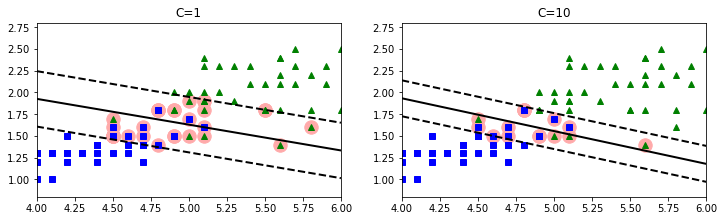

In [119]:
plt.figure(figsize=(12,3.2))
# C = 1 plot
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(clf1, 4, 6)
plt.axis([4, 6, 0.8, 2.8])
plt.title("C=" + str(clf1.get_params()['C']))

# C = 20 plot
plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(clf2, 4, 6)
plt.axis([4, 6, 0.8, 2.8])
plt.title("C=" + str(clf2.get_params()['C']))


plt.show()